<a href="https://colab.research.google.com/github/snekumar/AD_cnn/blob/main/3d_cnn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

## Installing Packages

In [1]:
from google.colab import drive
drive.mount('projectm')

Mounted at projectm


In [5]:
!pip install classification-models-3D Keras-Applications -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


## Import Statements

In [6]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import wandb
from classification_models_3D.tfkeras import Classifiers
from ipywidgets import IntSlider, interact

from matplotlib import animation, rc
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from scipy import ndimage
from scipy.ndimage import zoom
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv3D, Dense,
                                     Dropout, GlobalAveragePooling3D,
                                     MaxPool3D)
from tensorflow.keras.optimizers import Adam
from wandb.keras import WandbCallback

## Random Seed for Reproducibility

In [ ]:
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Weights & Biases Setup

In [ ]:
user_secrets = UserSecretsClient()

wandb.login(key=user_secrets.get_secret('WANDB_API_KEY'))
run = wandb.init(
    name='7-mw-3D-CNN2-resnet50-MCI-NC',
    project=user_secrets.get_secret('WANDB_ADNI_PROJECT'),
    entity=user_secrets.get_secret('WANDB_ENTITY'),
    id='7-mw-3D-CNN2-resnet50-MCI-NC',
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nexer8. Use `wandb login --relogin` to force relogin


## Project Configuration

In [ ]:
wandb.config = {
    'learning_rate': 1e-5,
    'min_learning_rate': 1e-8,
    'epochs': 200,
    'batch_size': 4,
    'test_batch_size': 1,
#     'img_size': 128,
#     'depth': 64,
    'n_classes': 2
}

config = wandb.config

Data load and Preprocessing



In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    return volume.astype('float32')


def resize_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]
    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
#     volume = resize_volume(
#         volume, config['img_size'], config['img_size'], config['depth']
#     )
    return volume

 Class Distribution

In [ ]:
# ad_paths = [
#     os.path.join(os.getcwd(), '/kaggle/input/3cla-adni/AD', x)
#     for x in os.listdir('/kaggle/input/3cla-adni/AD')
# ]

mci_paths = [
    os.path.join(os.getcwd(), '/kaggle/input/3cla-adni/MCI', x)
    for x in os.listdir('/kaggle/input/3cla-adni/MCI')
]

nc_paths = [
    os.path.join(os.getcwd(), '/kaggle/input/3cla-adni/NC', x)
    for x in os.listdir('/kaggle/input/3cla-adni/NC')
]

# print(f'Number of AD images: {len(ad_paths)}')
print(f'Number of MCI images: {len(mci_paths)}')
print(f'Number of NC images: {len(nc_paths)}')

Number of MCI images: 278
Number of NC images: 346


Build Train

In [ ]:
mci_labels = np.array([0 for _ in range(len(mci_paths))])
# ad_labels = np.array([1 for _ in range(len(ad_paths))])
nc_labels = np.array([1 for _ in range(len(nc_paths))])
CLASS_NAMES = ['MCI', 'NC']

# labels = np.concatenate((np.concatenate((mci_labels, ad_labels), axis=0), nc_labels), axis=0)
labels = np.concatenate((mci_labels, nc_labels), axis=0)
# paths = np.concatenate((np.concatenate((mci_paths, ad_paths), axis=0), nc_paths), axis=0)
paths = np.concatenate((mci_paths, nc_paths), axis=0)

In [ ]:
train_indices, test_indices = next(
    StratifiedShuffleSplit(1, train_size=0.8, random_state=seed).split(
        paths, labels
    )
)

tmp_labels = [labels[idx] for idx in train_indices]
tmp_paths = [paths[idx] for idx in train_indices]

tmp_train_indices, tmp_val_indices = next(
    StratifiedShuffleSplit(1, train_size=0.8, random_state=seed).split(
        tmp_paths, tmp_labels
    )
)

tmp_train_paths = [tmp_paths[idx] for idx in tmp_train_indices]
tmp_val_paths = [tmp_paths[idx] for idx in tmp_val_indices]

train_indices = [paths.tolist().index(path) for path in tmp_train_paths]
val_indices = [paths.tolist().index(path) for path in tmp_val_paths]

# Check if there are no common indices
assert bool(set(train_indices) & set(val_indices)) is False
assert bool(set(train_indices) & set(test_indices)) is False
assert bool(set(val_indices) & set(test_indices)) is False

print(
    'Number of samples:\n'
    f'train: {len(train_indices)}\n'
    f'validation: {len(val_indices)}\n'
    f'test: {len(test_indices)}'
)

Number of samples:
train: 399
validation: 100
test: 125


In [ ]:
def random_rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, indices, paths, labels, batch_size=4, dim=(113, 137, 113),
                 n_classes=2, shuffle=True, transform=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.paths = paths
        self.labels = labels
        self.indices = indices
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.transform = transform
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        indices_temp = [self.indices[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indices_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indices_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(indices_temp):
            # Store sample
            volume = process_scan(self.paths[ID])
            if self.transform is not None:
                volume = self.transform(volume)
            X[i,] = np.expand_dims(volume, axis=3)

            # Store class
            y[i] = self.labels[ID]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
training_generator = DataGenerator(
    train_indices,
    paths,
    labels,
    batch_size=config['batch_size'],
    shuffle=True,
    transform=random_rotate,
)

validation_generator = DataGenerator(
    val_indices,
    paths,
    labels,
    batch_size=config['batch_size'],
    shuffle=True,
)

test_generator = DataGenerator(
    test_indices,
    paths,
    labels,
    batch_size=config['test_batch_size'],
    shuffle=False,
)

Dimensions of the CT scan are: (113, 137, 113, 1)


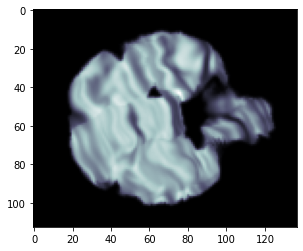

In [ ]:
images = process_scan(paths[0])
images = np.expand_dims(images, axis=3)
images = np.expand_dims(images, axis=0)
image = images[0]

print('Dimensions of the CT scan are:', image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap='bone')

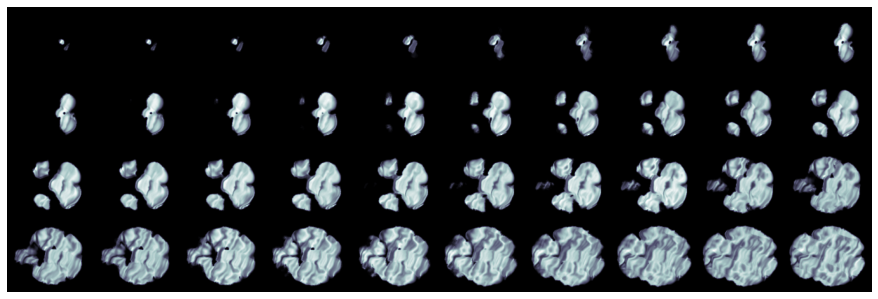

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    _, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios': heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap='bone')
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 40 slices of the CT scan.
plot_slices(4, 10, 113, 137, image[:, :, :40])

# 3D Convolutional Neural Network


In [ ]:
def get_model(height=113, width=137, depth=113):
    """Build a 3D convolutional neural network model."""
    modelPoint, _ = Classifiers.get('resnet50')
    net = modelPoint(
        input_shape=(height, width, depth, 1),
        include_top=False,
        weights=None,
    )

    x = net.layers[-1].output
    x = GlobalAveragePooling3D()(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dense(units=64, activation='relu')(x)
    outputs = Dense(units=config['n_classes'], activation='softmax')(x)

    return Model(net.inputs, outputs, name='3D-ResNet50')


# Build model.
model = get_model(height=113, width=137, depth=113)
# model.summary()

## Model Training

In [ ]:
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=config['learning_rate']),
    metrics=['acc'],
)

# Train the model, doing validation at the end of each epoch
model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=config['epochs'],
    verbose=2,
    callbacks=[
        ModelCheckpoint('best.h5', save_best_only=True, monitor='val_loss', mode='min'),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            patience=7,
            factor=0.5,
            min_lr=config['min_learning_rate'],
        ),
        EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True),
        WandbCallback(mode='min'),
    ],
    workers=6
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/200
99/99 - 141s - loss: 0.6915 - acc: 0.5581 - val_loss: 0.6898 - val_acc: 0.6100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask

Epoch 2/200
99/99 - 109s - loss: 0.6729 - acc: 0.5833 - val_loss: 0.7042 - val_acc: 0.4500
Epoch 3/200
99/99 - 113s - loss: 0.6693 - acc: 0.5758 - val_loss: 0.6765 - val_acc: 0.5800


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask

Epoch 4/200
99/99 - 109s - loss: 0.6654 - acc: 0.5960 - val_loss: 0.6775 - val_acc: 0.4900
Epoch 5/200
99/99 - 109s - loss: 0.6429 - acc: 0.6364 - val_loss: 0.6667 - val_acc: 0.6100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/200
99/99 - 109s - loss: 0.6322 - acc: 0.6389 - val_loss: 0.6893 - val_acc: 0.5100
Epoch 7/200
99/99 - 110s - loss: 0.6387 - acc: 0.6187 - val_loss: 0.6459 - val_acc: 0.6200


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/200
99/99 - 109s - loss: 0.6201 - acc: 0.6717 - val_loss: 0.6855 - val_acc: 0.5200
Epoch 9/200
99/99 - 110s - loss: 0.5998 - acc: 0.6717 - val_loss: 0.6003 - val_acc: 0.6800


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask

Epoch 10/200
99/99 - 110s - loss: 0.6241 - acc: 0.6111 - val_loss: 0.6930 - val_acc: 0.5800
Epoch 11/200
99/99 - 113s - loss: 0.5938 - acc: 0.6843 - val_loss: 0.7850 - val_acc: 0.5100
Epoch 12/200
99/99 - 110s - loss: 0.5711 - acc: 0.7096 - val_loss: 0.8289 - val_acc: 0.5200
Epoch 13/200
99/99 - 110s - loss: 0.5608 - acc: 0.6944 - val_loss: 0.6254 - val_acc: 0.5600
Epoch 14/200
99/99 - 112s - loss: 0.5733 - acc: 0.6843 - val_loss: 0.5938 - val_acc: 0.6500


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/200
99/99 - 112s - loss: 0.5246 - acc: 0.7601 - val_loss: 1.4016 - val_acc: 0.4700
Epoch 16/200
99/99 - 112s - loss: 0.5349 - acc: 0.7399 - val_loss: 0.6359 - val_acc: 0.6200
Epoch 17/200
99/99 - 113s - loss: 0.5225 - acc: 0.7247 - val_loss: 0.5592 - val_acc: 0.6900


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/200
99/99 - 109s - loss: 0.5150 - acc: 0.7298 - val_loss: 0.6392 - val_acc: 0.6200
Epoch 19/200
99/99 - 112s - loss: 0.4607 - acc: 0.7854 - val_loss: 0.6446 - val_acc: 0.6500
Epoch 20/200
99/99 - 109s - loss: 0.5022 - acc: 0.7576 - val_loss: 1.1968 - val_acc: 0.5600
Epoch 21/200
99/99 - 114s - loss: 0.4772 - acc: 0.7424 - val_loss: 0.5697 - val_acc: 0.7400
Epoch 22/200
99/99 - 114s - loss: 0.4648 - acc: 0.7803 - val_loss: 1.5471 - val_acc: 0.5600
Epoch 23/200
99/99 - 109s - loss: 0.4429 - acc: 0.7955 - val_loss: 0.7046 - val_acc: 0.6500
Epoch 24/200
99/99 - 114s - loss: 0.4831 - acc: 0.7551 - val_loss: 0.6366 - val_acc: 0.6600
Epoch 25/200
99/99 - 113s - loss: 0.3676 - acc: 0.8485 - val_loss: 0.6364 - val_acc: 0.6200
Epoch 26/200
99/99 - 112s - loss: 0.4145 - acc: 0.8308 - val_loss: 0.7354 - val_acc: 0.5900
Epoch 27/200
99/99 - 115s - loss: 0.3689 - acc: 0.8510 - val_loss: 0.7567 - val_acc: 0.6200
Epoch 28/200
99/99 - 113s - loss: 0.3568 - acc: 0.8308 - val_loss: 0.7715 - val_

Visualizing Training History



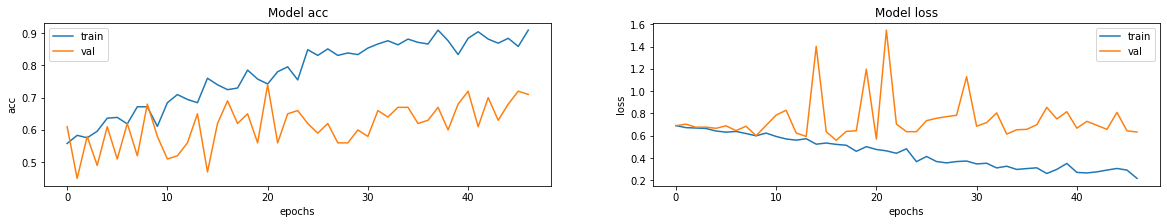

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['acc', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Cleanup

In [ ]:
wandb.finish()

acc,▁▂▁▂▃▃▃▃▂▄▄▄▅▅▄▄▆▅▅▆▅▇▆▆▇▆▇▇▇▇▇▇█▇▇█▇▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁
lr,█████████████████████▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▅▁▄▂▅▂▃▇▄▂▃▄▁▅▇▅▆█▄▆▆▅▄▄▄▅▄▆▆▆▅▅▆▅█▅▇▅▇▇
val_loss,▂▂▂▂▂▂▂▁▂▃▃▁▇▂▁▂▂▁█▂▂▂▂▃▃▅▂▂▁▂▂▂▃▂▂▂▂▂▃▂
GFLOPS,39.41818
acc,0.90909
best_epoch,16
best_val_loss,0.55918
epoch,46


In [ ]:
model.load_weights('best.h5')
input_volume = test_generator.__getitem__(1)[0]

prediction = model.predict(input_volume)[0]
print(prediction)

[0.52646464 0.47353536]


Model Evaluation

In [ ]:
y_pred = [np.argmax(x) for x in model.predict(test_generator, batch_size=config['batch_size'])]
y_test = [labels[idx] for idx in test_indices]

 Classification Report

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.531     0.464     0.495        56
           1      0.605     0.667     0.634        69

    accuracy                          0.576       125
   macro avg      0.568     0.565     0.565       125
weighted avg      0.572     0.576     0.572       125



Confusion Matrix

<AxesSubplot:>

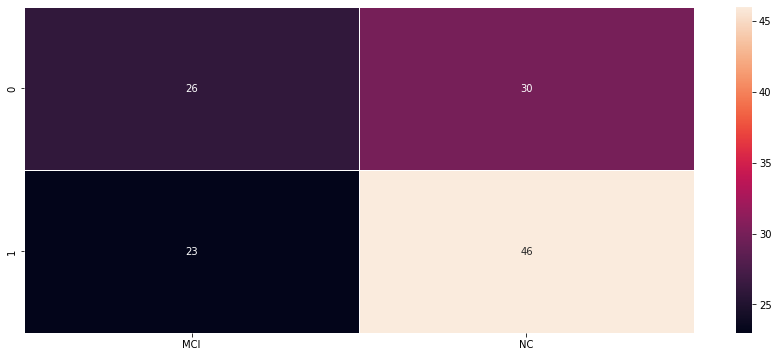

In [ ]:
cfsn_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cfsn_matrix, index=range(config['n_classes']), columns=CLASS_NAMES)
plt.figure(figsize=(15, 6))
sn.heatmap(df_cm, annot=True, linewidths=0.5, fmt='d')

In [ ]:
volume_size = input_volume.shape
last_conv_layer_name = 'relu1'

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel (equivalent to global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
print(input_volume.shape)

(1, 113, 137, 113, 1)


In [ ]:
# Remove last layer's activation
model.layers[-1].activation = None

# Print what the top predicted class is
input_volume = input_volume[0:1, :, :, :, :]
img_arary = input_volume

preds = model.predict(img_array)
print('Predicted:', preds[0])

input_volume = np.squeeze(input_volume)
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

NameError: name 'img_array' is not defined

In [ ]:
plt.matshow(np.squeeze(heatmap[:, :, 1]))
plt.show()

## Expanding Heatmap Dimensions

Notice that similarly to resizing the input volume, expanding the heatmap dimensions is based on the *spline interpolated zoom*.

In [ ]:
def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap


resized_heatmap = get_resized_heatmap(heatmap, input_volume.shape)

# Visualizations

Now it is time for us to graphically visualize the results obtained by overlaying the heatmap with the image. We utilize the `jet` colormap for this.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

In [ ]:
def get_bounding_boxes(heatmap, threshold=0.15, otsu=False):
    """Get bounding boxes from heatmap"""
    p_heatmap = np.copy(heatmap)

    if otsu:
        # Otsu's thresholding method to find the bounding boxes
        threshold, p_heatmap = cv2.threshold(
            heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    else:
        # Using a fixed threshold
        p_heatmap[p_heatmap < threshold * 255] = 0
        p_heatmap[p_heatmap >= threshold * 255] = 1

    # find the contours in the thresholded heatmap
    contours = cv2.findContours(p_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # get the bounding boxes from the contours
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        bboxes.append([x, y, x + w, y + h])

    return bboxes


def get_bbox_patches(bboxes, color='r', linewidth=2):
    """Get patches for bounding boxes"""
    patches = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patches.append(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                edgecolor=color,
                facecolor='none',
                linewidth=linewidth,
            )
        )
    return patches

In [ ]:
# show the bounding boxes on the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())

bboxes = get_bounding_boxes(np.squeeze(resized_heatmap[:, :, 30]))
patches = get_bbox_patches(bboxes)

for patch in patches:
    ax[1].add_patch(patch)

plt.show()

In [ ]:
def _draw_line(ax, coords, clr='g'):
    line = Path(coords, [Path.MOVETO, Path.LINETO])
    pp = PathPatch(line, linewidth=3, edgecolor=clr, facecolor='none')
    ax.add_patch(pp)


def _set_axes_labels(ax, axes_x, axes_y):
    ax.set_xlabel(axes_x)
    ax.set_ylabel(axes_y)
    ax.set_aspect('equal', 'box')


def _draw_bboxes(ax, heatmap):
    bboxes = get_bounding_boxes(heatmap, otsu=True)
    patches = get_bbox_patches(bboxes)
    for patch in patches:
        ax.add_patch(patch)


_rec_prop = dict(linewidth=5, facecolor='none')


def show_volume(vol, z, y, x, heatmap=None, alpha=0.3, fig_size=(6, 6)):
    """Show a slice of a volume with optional heatmap"""
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=fig_size)
    v_z, v_y, v_x = vol.shape

    img0 = axarr[0, 0].imshow(vol[z, :, :], cmap='bone')
    if heatmap is not None:
        axarr[0, 0].imshow(
            heatmap[z, :, :], cmap='jet', alpha=alpha, extent=img0.get_extent()
        )
        _draw_bboxes(axarr[0, 0], heatmap[z, :, :])

    axarr[0, 0].add_patch(Rectangle((-1, -1), v_x, v_y, edgecolor='r', **_rec_prop))
    _draw_line(axarr[0, 0], [(x, 0), (x, v_y)], 'g')
    _draw_line(axarr[0, 0], [(0, y), (v_x, y)], 'b')
    _set_axes_labels(axarr[0, 0], 'X', 'Y')

    img1 = axarr[0, 1].imshow(vol[:, :, x].T, cmap='bone')
    if heatmap is not None:
        axarr[0, 1].imshow(
            heatmap[:, :, x].T, cmap='jet', alpha=alpha, extent=img1.get_extent()
        )
        _draw_bboxes(axarr[0, 1], heatmap[:, :, x].T)

    axarr[0, 1].add_patch(Rectangle((-1, -1), v_z, v_y, edgecolor='g', **_rec_prop))
    _draw_line(axarr[0, 1], [(z, 0), (z, v_y)], 'r')
    _draw_line(axarr[0, 1], [(0, y), (v_x, y)], "b")
    _set_axes_labels(axarr[0, 1], 'Z', 'Y')

    img2 = axarr[1, 0].imshow(vol[:, y, :], cmap='bone')
    if heatmap is not None:
        axarr[1, 0].imshow(
            heatmap[:, y, :], cmap='jet', alpha=alpha, extent=img2.get_extent()
        )
        _draw_bboxes(axarr[1, 0], heatmap[:, y, :])

    axarr[1, 0].add_patch(Rectangle((-1, -1), v_x, v_z, edgecolor='b', **_rec_prop))
    _draw_line(axarr[1, 0], [(0, z), (v_x, z)], 'r')
    _draw_line(axarr[1, 0], [(x, 0), (x, v_y)], 'g')
    _set_axes_labels(axarr[1, 0], 'X', 'Z')
    axarr[1, 1].set_axis_off()
    fig.tight_layout()


def interactive_show(volume, heatmap=None):
    """Show a volume interactively"""
    # transpose volume from (x, y, z) to (z, y, x)
    volume = np.transpose(volume, (2, 0, 1))
    if heatmap is not None:
        heatmap = np.transpose(heatmap, (2, 0, 1))
    vol_shape = volume.shape

    interact(
        lambda x, y, z: plt.show(show_volume(volume, z, y, x, heatmap)),
        z=IntSlider(min=0, max=vol_shape[0] - 1, step=1, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1] - 1, step=1, value=int(vol_shape[1] / 2)),
        x=IntSlider(min=0, max=vol_shape[2] - 1, step=1, value=int(vol_shape[2] / 2)),
    )

In [ ]:
interactive_show(input_volume)

In [ ]:
interactive_show(input_volume, resized_heatmap)